# Optimising the Optimisation
In this notebook, I look at how many inducing points, latent functions and LMC components I need to train the prediction model to beat a simple baseline.

I'll look at the ONeil dataset, in the LTO setting, using processed viability to predict the missing triplets. For comparison we use the simple Bliss non-interaction assumption.

Focussing on a single cell line, and a subset of the drugs, I can quickly get a sense of how many latent functions I need and how many inducing points they need.

In [1]:
import torch
import gpytorch
import pimogp
from pimogp.utils.utils import train_test_split_drugdata, prepdata
from pimogp.utils.runModel import runmodel

In [87]:
# Set some parameters
input_type = "processed"
targets = "fMean"
predtarget = "viability"
dataset = "ONeil"
seed = 12
setting = "LTO"
data, train, test, ids = train_test_split_drugdata(input_type=input_type,dataset=dataset,setting=setting,seed=seed)

In [88]:
# Just subset the data here to see if the number of inducing points were the issue
drugList = data["drugA"].unique()[0:8]

In [89]:
drugList

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'Bortezomib',
       'Carboplatin', 'Cyclophosphamide', 'Dasatinib'], dtype=object)

In [90]:
train = train[train['drugA'].isin(drugList)]
train = train[train['drugB'].isin(drugList)]
test = test[test['drugA'].isin(drugList)]
test = test[test['drugB'].isin(drugList)]

In [91]:
train['cell_line'].unique()

array(['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1',
       'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP',
       'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23',
       'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO',
       'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D',
       'UACC62', 'UWB1289', 'UWB1289BRCA1', 'VCAP', 'ZR751'], dtype=object)

In [92]:
train

,cell_line,drugA,drugB,drugA_conc,drugB_conc,GPMean,GPVar,fMean,fVar,p0Mean,...,Blatent_247,Blatent_248,Blatent_249,Blatent_250,Blatent_251,Blatent_252,Blatent_253,Blatent_254,Blatent_255,task_index
100,A2058,5-FU,AZD1775,0.0,0.000000,-0.013604,1.045780,0.999671,0.000001,0.999978,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
101,A2058,5-FU,AZD1775,0.0,0.111111,-0.019983,1.011360,0.999656,0.000004,0.999977,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
102,A2058,5-FU,AZD1775,0.0,0.222222,-0.035324,0.974131,0.999599,0.000016,0.999961,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
103,A2058,5-FU,AZD1775,0.0,0.333333,-0.055318,0.939041,0.999442,0.000015,0.999812,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
104,A2058,5-FU,AZD1775,0.0,0.444444,-0.069008,0.890884,0.997371,0.000023,0.998224,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845295,ZR751,Dasatinib,BEZ-235,1.0,0.555556,0.836623,0.201252,0.758781,0.004745,0.578707,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1845296,ZR751,Dasatinib,BEZ-235,1.0,0.666667,0.145741,0.131897,0.501934,0.006623,0.467011,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1845297,ZR751,Dasatinib,BEZ-235,1.0,0.777778,-0.305510,0.077650,0.283945,0.002499,0.353702,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1845298,ZR751,Dasatinib,BEZ-235,1.0,0.888889,-0.134187,0.130631,0.229313,0.003303,0.255643,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38


In [93]:
# Will focus on a single cell line, A2058
cell_line = "A2058"
train = train[train['cell_line'] == cell_line]
#train = train.iloc[0:5000]
test = test[test['cell_line'] == cell_line] 
#test = test.iloc[0:5000]
y_train, X_train, train_indices, train_noise, train_weights = prepdata(train, targets, predtarget,num_latents=256)
y_test, X_test, test_indices, test_noise, test_weights = prepdata(test, targets, predtarget,num_latents=256)

In [94]:
X_train[0:5]

tensor([[ 0.0000,  0.0000, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.1111, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.2222, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.3333, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.4444, -0.5473,  ..., -0.0341, -2.1013,  0.1160]])

In [95]:
X_train.shape

torch.Size([1900, 514])

In [96]:
X_test.shape

torch.Size([600, 514])

In [97]:
G = 1
num_latents = 2
num_inducing = 500
batch_size = 256
num_tasks = train_indices.max()+1
num_epochs = 400
initial_lr = 0.01
num_drug_latents = 256

In [98]:
from torch.utils.data import TensorDataset,  DataLoader
train_dataset = TensorDataset(X_train,y_train,train_noise,train_indices)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

# Define the permutation
permutation = torch.cat([torch.tensor([1]), torch.tensor([0]),
                             torch.linspace((2 + num_drug_latents), 1 + (2 * num_drug_latents), num_drug_latents), 
                         torch.linspace(2, 1 + num_drug_latents, num_drug_latents)]).long()


In [99]:
next(iter(train_loader))

[tensor([[ 0.7778,  0.8889, -0.4313,  ..., -0.2326, -1.5715, -0.0110],
         [ 1.0000,  0.0000, -0.4313,  ...,  0.3296, -1.5032, -0.0834],
         [ 0.6667,  0.6667,  0.5331,  ..., -0.7550, -2.1108, -0.5716],
         ...,
         [ 0.1111,  0.1111, -0.5473,  ..., -0.7600, -1.8868, -0.4474],
         [ 0.3333,  0.2222, -0.1585,  ..., -0.2326, -1.5715, -0.0110],
         [ 0.2222,  0.7778, -0.5972,  ...,  0.3296, -1.5032, -0.0834]]),
 tensor([1.8019e-01, 9.6530e-01, 7.1054e-01, 1.2100e-02, 5.3014e-01, 6.1358e-01,
         3.1061e-03, 4.8510e-01, 8.3207e-01, 9.0335e-01, 9.9980e-01, 9.8844e-01,
         9.9805e-01, 9.9851e-01, 7.8538e-01, 7.4445e-01, 2.6230e-01, 1.8394e-04,
         3.2934e-01, 1.1691e-01, 9.2331e-04, 8.0022e-01, 9.9969e-01, 7.4328e-01,
         5.9731e-01, 5.8803e-01, 5.5816e-01, 6.9664e-01, 8.2641e-01, 9.3165e-01,
         9.8065e-01, 5.4306e-02, 9.9828e-01, 9.9871e-01, 9.9392e-01, 9.9508e-01,
         3.9886e-01, 9.7359e-01, 9.7119e-01, 7.9409e-01, 9.9027e-01, 6.4

In [100]:
from torch import Tensor
from typing import Literal
from pimogp.kernels.permutation_invariant_rbf import PermutationInvariantRBFKernel
from pimogp.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from botorch.models.utils.inducing_point_allocators import GreedyVarianceReduction

class TestModel(gpytorch.models.ApproximateGP):
    r"""
    DrugComboModelICM_NC is the model for drug combination prediction that utilizes drug covariates, but
    no cell line covariates

    It wraps a PermutationInvariantVariationalStrategy in an LMCVariationalStrategy for a multi-output GP.
    The parameters of the LMC are learned "free-form" as opposed to making use of cell line information

    :param permutation: A Tensor giving the permutation the function should be invariant to
    :param conc_dims: The dimensions of the data input that corresponds to the drug concentrations
    :param drug_covar_dims: The dimension of the data input that corresponds to the drug covariates
    :param num_tasks: The number of tasks / outputs / cell lines
    :param num_latents: The number of latent functions in the LMC
    :param num_inducing: The number of inducing points per latent
    :param sample_inducing_from: A Tensor to sample inducing points from, usually this would be the training inputs
    :param inducing_weights: A vector of weights used in sampling of the inducing points
    :param vardistr: The variational distribution to use, mf=MeanField (Default), "nat"=Natural, "chol"=Cholesky
    """

    def __init__(self, permutation: Tensor,
                 num_tasks: int,
                 num_latents: int,
                 num_inducing: int,
                 inducing_weights,
                 sample_inducing_from: Tensor,
                 ):

        
        covar_module = gpytorch.kernels.ScaleKernel(PermutationInvariantRBFKernel(permutation=permutation,permute_forward=True,
                                                     ard_num_dims=514,lengthscale_constraint=gpytorch.constraints.LessThan(100.0)))

        # Initialise the lengthscales
        div = torch.zeros([514])
        div[0:2] = 2.0
        div[2:] = 2.0
        lengthscales_init = sample_inducing_from.var(dim=0).sqrt().div(div)
        covar_module.base_kernel.lengthscale = lengthscales_init


        # Sample inducing points
        #p = inducing_weights.div(inducing_weights.sum())
        #idx = p.multinomial(num_samples=num_inducing * num_latents, replacement=False).reshape(num_latents,
        #                                                                                       num_inducing)
        #inducing_points = sample_inducing_from[idx]

        ind_allocator = GreedyVarianceReduction()
        inducing_points = torch.empty((0, num_inducing, sample_inducing_from.size(1)))
        for i in range(num_latents):
            sample = ind_allocator.allocate_inducing_points(sample_inducing_from, covar_module,
                                                num_inducing=num_inducing, input_batch_shape=torch.Size([]))
            inducing_points = torch.cat((inducing_points, sample.unsqueeze(0)), dim=0)
            matches = (sample_inducing_from.unsqueeze(1) == sample).all(dim=2)
            row_matches = matches.any(dim=1)
            sample_inducing_from = sample_inducing_from[~row_matches]
        #inducing_points = ind_allocator.allocate_inducing_points(sample_inducing_from,
        #                                                         covar_module,num_inducing=num_inducing,
        #                                                         input_batch_shape=torch.Size([num_latents]))

        # Now turn of the permutation forward
        #covar_module.permute_forward = False
        
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Variational Strategy
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            #PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution,
                #permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1)

        super(TestModel, self).__init__(variational_strategy)

        # Store permutation here
        

        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ConstantMean()
        # Covar over the concentrations, simple RBF
        #self.covar_module_concentrations = covar_module_concentrations
        # Covar over the drugs, RBF + ARD
        #self.covar_module_drugs = covar_module_drugs
        self.covar_module = covar_module



    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        #covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [101]:
# Set up model and likelihood
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
model = TestModel(permutation=permutation, num_tasks = num_tasks, num_latents=num_latents, num_inducing=num_inducing,sample_inducing_from=X_train,inducing_weights=train_weights)
likelihood = GaussianLikelihood()
#likelihood = FixedNoiseGaussianLikelihood(noise=torch.tensor([0.01]))

Index 0 given to:  (0, 1)
Index 1 given to:  (2, 258)
Index 2 given to:  (3, 259)
Index 3 given to:  (4, 260)
Index 4 given to:  (5, 261)
Index 5 given to:  (6, 262)
Index 6 given to:  (7, 263)
Index 7 given to:  (8, 264)
Index 8 given to:  (9, 265)
Index 9 given to:  (10, 266)
Index 10 given to:  (11, 267)
Index 11 given to:  (12, 268)
Index 12 given to:  (13, 269)
Index 13 given to:  (14, 270)
Index 14 given to:  (15, 271)
Index 15 given to:  (16, 272)
Index 16 given to:  (17, 273)
Index 17 given to:  (18, 274)
Index 18 given to:  (19, 275)
Index 19 given to:  (20, 276)
Index 20 given to:  (21, 277)
Index 21 given to:  (22, 278)
Index 22 given to:  (23, 279)
Index 23 given to:  (24, 280)
Index 24 given to:  (25, 281)
Index 25 given to:  (26, 282)
Index 26 given to:  (27, 283)
Index 27 given to:  (28, 284)
Index 28 given to:  (29, 285)
Index 29 given to:  (30, 286)
Index 30 given to:  (31, 287)
Index 31 given to:  (32, 288)
Index 32 given to:  (33, 289)
Index 33 given to:  (34, 290)
I

In [102]:
likelihood.noise

tensor([0.6932], grad_fn=<AddBackward0>)

In [103]:
model.covar_module.base_kernel.lengthscale

tensor([[0.1596, 0.1596, 0.2331, 0.1884, 0.2253, 0.1032, 0.1609, 0.3116, 0.0889,
         0.7089, 0.1025, 0.1117, 0.9052, 0.2188, 0.2909, 0.1980, 0.2732, 0.2069,
         0.1373, 0.1234, 0.3488, 0.2885, 0.1694, 0.4852, 0.1122, 0.2796, 0.2899,
         0.0711, 0.2116, 0.1197, 0.2628, 0.1649, 0.1893, 0.2743, 0.1546, 0.3521,
         0.1004, 0.1169, 0.1319, 0.1126, 0.1786, 0.2201, 0.1409, 0.1383, 0.1945,
         0.1078, 0.2074, 0.0534, 0.1970, 0.1298, 0.3306, 0.1606, 0.1362, 0.3668,
         0.1566, 0.1142, 0.1175, 0.2052, 0.1283, 0.2744, 0.6728, 0.2917, 0.0720,
         0.2295, 0.1201, 0.1425, 0.2420, 0.1192, 0.1458, 0.1525, 0.3951, 0.4113,
         0.3007, 0.2343, 0.1626, 0.0891, 0.2192, 0.1529, 0.1215, 0.1661, 0.1506,
         0.3365, 0.1340, 0.0718, 0.1730, 0.0500, 0.1127, 0.2356, 0.3930, 0.3433,
         0.2766, 0.1588, 0.2435, 0.2273, 0.4307, 0.0968, 0.0771, 0.2213, 0.2955,
         0.1776, 0.1309, 0.2776, 0.0866, 0.1866, 0.2925, 0.2062, 0.1268, 0.1330,
         0.1146, 0.2181, 0.1

In [104]:
model.variational_strategy.base_variational_strategy.inducing_points.shape

torch.Size([2, 500, 514])

In [105]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-0.7884],
        [ 0.7800]], requires_grad=True)

In [106]:
from torch.optim.lr_scheduler import MultiStepLR
from gpytorch.mlls import VariationalELBO
# Now define the loss and set up the optimization
hyperparameter_optimizer = None
variational_ngd_optimizer = None
scheduler_hypers = None
scheduler_variational = None
vardistr = "nat"
if vardistr == "nat":
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr = initial_lr)
    variational_ngd_optimizer = gpytorch.optim.NGD(
        model.variational_parameters(),
        num_data=y_train.size(0), lr=float(10*initial_lr))
    scheduler_variational = MultiStepLR(variational_ngd_optimizer,
                                        milestones=[int(0.25*num_epochs),int(0.5*num_epochs),int(0.75*num_epochs)],
                                        gamma=0.5)
else:
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=initial_lr)

scheduler_hypers = MultiStepLR(hyperparameter_optimizer,
                               milestones=[int(0.25*num_epochs),int(0.5 * num_epochs), int(0.75 * num_epochs)],
                               gamma=0.5)

# Defining the loss:
mll = VariationalELBO(likelihood,model,num_data=y_train.size(0))

# Tracking loss
train_loss = []

In [107]:
from tqdm.autonotebook import tqdm
# Begin training
with gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False), gpytorch.settings.debug(state=False):
    epochs_iter = tqdm(range(num_epochs),desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, y_noise_batch, task_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer.zero_grad()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.zero_grad()
    
            # Get outputs
            output = model(x_batch,task_indices=task_batch)
            
    
            # Compute loss
            if isinstance(likelihood, gpytorch.likelihoods.FixedNoiseGaussianLikelihood):
                loss = -mll(output, y_batch, noise=(y_noise_batch+0.01))
            else:
                loss = -mll(output, y_batch)
            # Call backward on loss
            loss.backward()
            # Take a step
            hyperparameter_optimizer.step()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.step()
    
            # Update counter
            minibatch_iter.set_postfix(loss=loss.item(),drug1_lengthscale = model.covar_module.base_kernel.lengthscale[0][2].item())
    
            # Track loss
            train_loss.append(loss.item())
    
        # Step learning rate scheduler
        scheduler_hypers.step()
        if scheduler_variational is not None:
            scheduler_variational.step()

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leiv/opt/anaconda3/envs/pimogp/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/leiv/opt/anaconda3/envs/pimogp/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leiv/opt/anaconda3/envs/pimogp/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/8 [00:00<?, ?it/s]

In [108]:
model.covar_module.base_kernel.lengthscale

tensor([[ 0.2786,  0.2786,  8.0343,  6.6035,  7.6387,  3.6832,  3.9853,  7.7641,
          3.6928, 11.5442,  4.6175,  4.1324,  9.2308,  7.0170,  8.7696,  6.3915,
          8.1590,  5.7224,  5.5586,  5.1129, 10.0211,  8.0746,  5.8807, 10.2964,
          4.5516,  7.8679,  8.5113,  3.0525,  7.0132,  4.5654,  7.5012,  5.3686,
          5.8343,  5.6273,  5.8291,  6.7961,  4.0343,  5.0122,  4.4734,  4.3778,
          6.7885,  7.3331,  4.5182,  5.9913,  5.9013,  5.1267,  6.9711,  2.4013,
          4.6839,  5.2455,  5.6661,  5.8090,  5.6577, 10.7543,  6.3165,  4.0449,
          4.5682,  7.6448,  4.7431,  7.3092, 10.0988,  8.8458,  3.4302,  8.2054,
          4.4917,  5.3523,  6.3497,  4.4976,  6.2790,  5.2065,  9.3025,  7.3940,
          7.0611,  7.8696,  6.1819,  3.6021,  7.1059,  5.3265,  4.4871,  6.0245,
          5.5373,  9.1836,  5.7316,  2.8647,  6.1133,  1.9358,  4.0154,  5.8569,
          8.7349,  7.9348,  6.2028,  6.1744,  6.9629,  7.4588,  9.5559,  4.4274,
          3.2380,  7.2574,  

In [109]:
likelihood.noise

tensor([0.0022], grad_fn=<AddBackward0>)

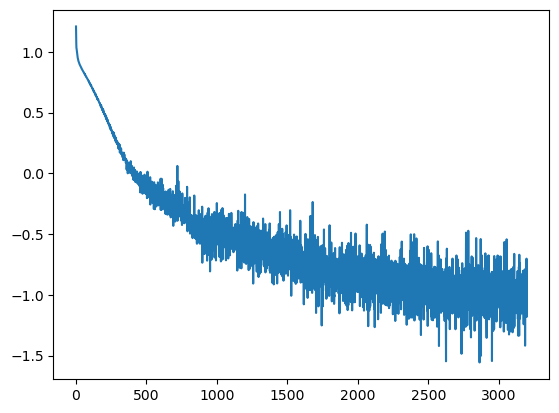

In [110]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.log(1.6+torch.tensor(train_loss)))

In [123]:
#test_dataset = TensorDataset(X_train, train_indices)
test_dataset = TensorDataset(X_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=256)

# Set into eval mode
model.eval()
likelihood.eval()
yhat = []
yvar = []
print("Predicting at test inputs")
with torch.no_grad(), gpytorch.settings.cholesky_max_tries(12):
    minibatch_iter = tqdm(test_loader,desc="Minibatch", leave=False)
    for x_batch, task_batch in minibatch_iter:
        predictions = (model(x_batch, task_indices=task_batch))
        mean = predictions.mean
        var = predictions.variance
        yhat.append(mean)
        yvar.append(var)
        

yhat_vector = torch.cat(yhat, 0)
yvar_vector = torch.cat(yvar,0)

Predicting at test inputs


Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

In [124]:
x_batch

tensor([[ 0.1111,  0.2222, -0.4313,  ..., -0.7550, -2.1108, -0.5716],
        [ 0.1111,  0.3333, -0.4313,  ..., -0.7550, -2.1108, -0.5716],
        [ 0.1111,  0.4444, -0.4313,  ..., -0.7550, -2.1108, -0.5716],
        ...,
        [ 1.0000,  0.7778, -0.4313,  ..., -0.7550, -2.1108, -0.5716],
        [ 1.0000,  0.8889, -0.4313,  ..., -0.7550, -2.1108, -0.5716],
        [ 1.0000,  1.0000, -0.4313,  ..., -0.7550, -2.1108, -0.5716]])

In [125]:
yhat_vector

tensor([ 0.9909,  0.9922,  0.9875,  1.0132,  1.0297,  0.9325,  0.6659,  0.3192,
         0.0738,  0.0469,  1.0083,  1.0009,  0.9851,  1.0086,  1.0336,  0.9426,
         0.6663,  0.2979,  0.0395,  0.0225,  1.0059,  0.9978,  0.9797,  1.0043,
         1.0351,  0.9484,  0.6684,  0.2920,  0.0334,  0.0306,  0.9980,  0.9941,
         0.9804,  1.0082,  1.0394,  0.9486,  0.6613,  0.2809,  0.0290,  0.0438,
         0.9896,  0.9884,  0.9784,  1.0060,  1.0299,  0.9273,  0.6310,  0.2515,
         0.0123,  0.0461,  0.9742,  0.9714,  0.9611,  0.9822,  0.9925,  0.8772,
         0.5796,  0.2128, -0.0079,  0.0398,  0.9342,  0.9284,  0.9164,  0.9295,
         0.9270,  0.8073,  0.5244,  0.1848, -0.0157,  0.0326,  0.8525,  0.8440,
         0.8335,  0.8439,  0.8373,  0.7275,  0.4764,  0.1751, -0.0079,  0.0258,
         0.7316,  0.7198,  0.7140,  0.7283,  0.7280,  0.6406,  0.4329,  0.1763,
         0.0095,  0.0215,  0.6023,  0.5863,  0.5848,  0.6046,  0.6141,  0.5536,
         0.3934,  0.1856,  0.0398,  0.03

In [126]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-0.3614],
        [-0.0005]], requires_grad=True)

In [127]:
model.covar_module

ScaleKernel(
  (base_kernel): PermutationInvariantRBFKernel(
    (raw_lengthscale_constraint): LessThan(1.000E+02)
  )
  (raw_outputscale_constraint): Positive()
)

In [128]:
print("our error: ",(y_train - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_train-torch.tensor(train["p0Mean"].values)).square().mean().sqrt())

RuntimeError: The size of tensor a (1900) must match the size of tensor b (600) at non-singleton dimension 0

In [129]:
print("our error: ",(y_test - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_test-torch.tensor(test["p0Mean"].values)).square().mean().sqrt())

our error:  tensor(0.2502)
baseline error:  tensor(0.0411, dtype=torch.float64)


our error:  tensor(0.2001, dtype=torch.float64)
baseline error:  tensor(0.0374, dtype=torch.float64)


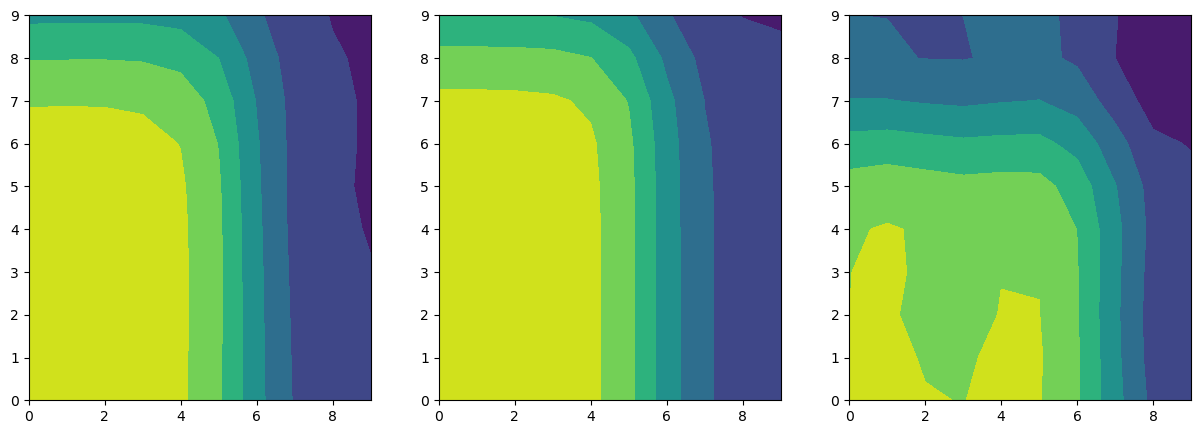

In [134]:
start = 100
end = start + 100

fhat = yhat_vector[start:end].reshape(10,10)
var = yvar_vector[start:end].reshape(10,10)
f = torch.tensor(train.iloc[start:end,7].values).reshape(10,10)
p0 = torch.tensor(train.iloc[start:end,9].values).reshape(10,10)
print("our error: ",(fhat-f).square().mean().sqrt())
print("baseline error: ",(p0-f).square().mean().sqrt())

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
axes[0].contourf(f)
axes[1].contourf(p0)
axes[2].contourf(fhat)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im,cax=cbar_ax)

#axes[0].set_title("True values")
#axes[1].set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'True values')

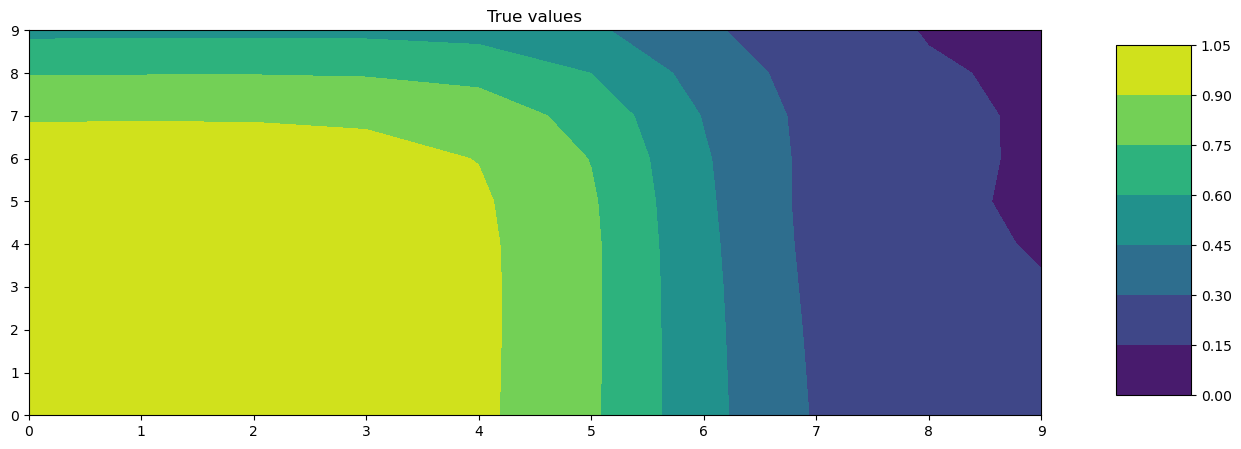

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
axes.contourf(f)
#axes[1].contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(f)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

axes.set_title("True values")
#axes[1].set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Baseline')

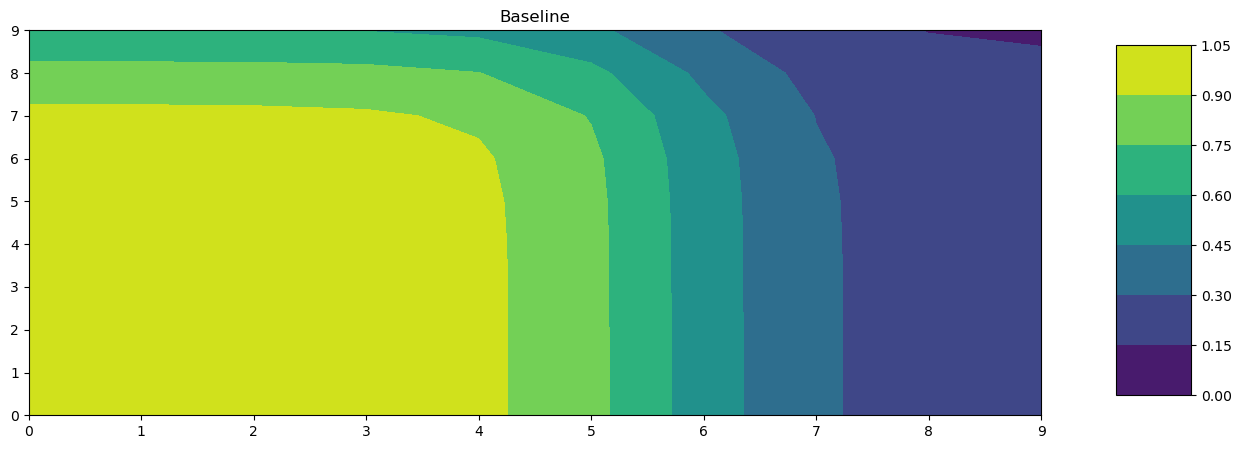

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
axes.contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(p0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
axes.set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Our Prediction')

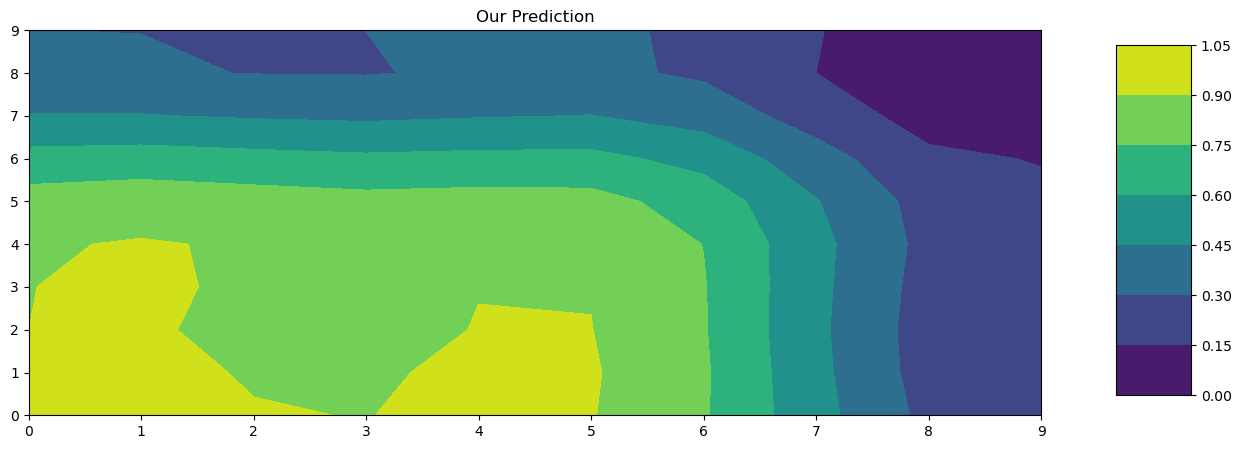

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
#axes.contourf(p0)
axes.contourf(fhat)
im = axes.contourf(fhat)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
#axes.set_title("Baseline")
axes.set_title("Our Prediction")

In [67]:
fhat

tensor([[ 0.9426,  0.9454,  0.9452,  0.9441,  0.9428,  0.9403,  0.9340,  0.9213,
          0.8996,  0.8676],
        [ 0.9938,  0.9962,  0.9950,  0.9929,  0.9910,  0.9883,  0.9823,  0.9696,
          0.9475,  0.9139],
        [ 1.0323,  1.0374,  1.0382,  1.0374,  1.0361,  1.0332,  1.0260,  1.0112,
          0.9856,  0.9477],
        [ 1.0309,  1.0391,  1.0426,  1.0438,  1.0434,  1.0400,  1.0309,  1.0129,
          0.9833,  0.9410],
        [ 0.9667,  0.9757,  0.9806,  0.9830,  0.9830,  0.9788,  0.9680,  0.9475,
          0.9156,  0.8718],
        [ 0.8302,  0.8361,  0.8396,  0.8416,  0.8411,  0.8363,  0.8248,  0.8042,
          0.7734,  0.7331],
        [ 0.6297,  0.6290,  0.6287,  0.6288,  0.6277,  0.6231,  0.6127,  0.5949,
          0.5695,  0.5380],
        [ 0.3916,  0.3825,  0.3776,  0.3759,  0.3751,  0.3723,  0.3652,  0.3530,
          0.3362,  0.3170],
        [ 0.1533,  0.1373,  0.1296,  0.1281,  0.1296,  0.1307,  0.1290,  0.1239,
          0.1169,  0.1107],
        [-0.0463, -

In [229]:
p0

tensor([[1.0000, 1.0000, 1.0000, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9999, 0.9999, 0.9999, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9998, 0.9998, 0.9998, 0.9997, 0.9981, 0.9798, 0.7895, 0.2170, 0.0456,
         0.0301],
        [0.9994, 0.9994, 0.9994, 0.9993, 0.9977, 0.9794, 0.7892, 0.2169, 0.0456,
         0.0300],
        [0.9983, 0.9983, 0.9983, 0.9981, 0.9965, 0.9783, 0.7883, 0.2167, 0.0455,
         0.0300],
        [0.9944, 0.9944, 0.9944, 0.9943, 0.9927, 0.9745, 0.7852, 0.2158, 0.0453,
         0.0299],
        [0.9812, 0.9812, 0.9812, 0.9811, 0.9795, 0.9616, 0.7748, 0.2130, 0.0447,
         0.0295],
        [0.9356, 0.9356, 0.9356, 0.9355, 0.9340, 0.9169, 0.7388, 0.2031, 0.0427,
         0.0281],
        [0.8028, 0.8028, 0.8028, 0.8027, 0.8014, 0.7868, 0.6340, 0.1743, 0.0366,
         0.0241],
        [0.6052, 0.6052, 0.6052, 0.6051, 0.6041, 0.5931, 0.4779, 0.1314, 0.0276,
         0.0182]], dtype=tor

In [217]:
(fhat-f).abs()

tensor([[0.0128, 0.0061, 0.0066, 0.0039, 0.0057, 0.0113, 0.0154, 0.0142, 0.0064,
         0.0079],
        [0.0079, 0.0073, 0.0083, 0.0072, 0.0077, 0.0076, 0.0054, 0.0018, 0.0024,
         0.0081],
        [0.0210, 0.0178, 0.0248, 0.0301, 0.0319, 0.0328, 0.0324, 0.0290, 0.0230,
         0.0172],
        [0.0004, 0.0009, 0.0122, 0.0198, 0.0210, 0.0177, 0.0109, 0.0008, 0.0088,
         0.0130],
        [0.0405, 0.0492, 0.0448, 0.0423, 0.0456, 0.0528, 0.0614, 0.0678, 0.0662,
         0.0520],
        [0.0042, 0.0271, 0.0362, 0.0433, 0.0511, 0.0568, 0.0573, 0.0493, 0.0287,
         0.0056],
        [0.1898, 0.1673, 0.1520, 0.1392, 0.1316, 0.1335, 0.1452, 0.1660, 0.1942,
         0.2263],
        [0.0295, 0.0430, 0.0287, 0.0260, 0.0222, 0.0281, 0.0148, 0.0764, 0.0778,
         0.1132],
        [0.1015, 0.0863, 0.0910, 0.1020, 0.1038, 0.0900, 0.0676, 0.0488, 0.0441,
         0.0583],
        [0.0653, 0.0810, 0.0713, 0.0560, 0.0523, 0.0633, 0.0783, 0.0835, 0.0706,
         0.0370]], dtype=tor

Text(0.5, 1.0, 'Predictive variance')

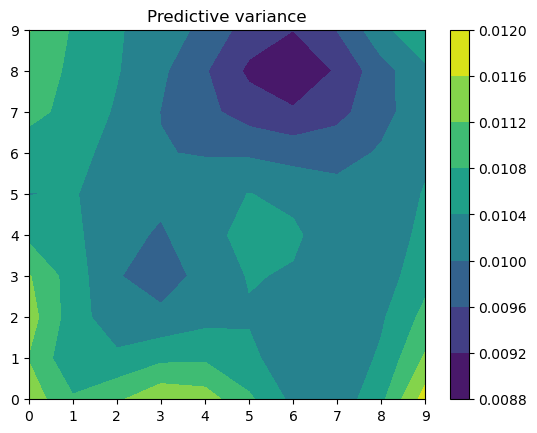

In [29]:
plt.contourf(var)
plt.colorbar()
plt.title("Predictive variance")